# Assessment-2-Code:-  Convolutional Neural Networks for CIFAR-10 multiclass image classification

In [1]:
# importing required libraries
import numpy as np
import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt
import os

import torch 
print("Pytorch library version =", torch.__version__)
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as data

## Libraries to build CNN Model
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

## Importing some Famous CNN models for comparasion
import torchvision.models as models

# Check for available GPU 
use_gpu = torch.cuda.is_available()

Pytorch library version = 1.8.2


In [2]:
# Custom Helper Functions to display images.

def Display_images(image,label,data_class_label):
    image = torchvision.utils.make_grid(image)
    image = image/2 + 0.5                    # Denormalize the image
    numpy_image = image.numpy()
    plt.imshow(np.transpose(numpy_image,(1,2,0)))
    plt.xlabel([data_class_label[int(labels[count])] for  count in range(batch_size)])
    plt.show()

## Loading CIFAR10 Dataset and displaying sample Images

Files already downloaded and verified


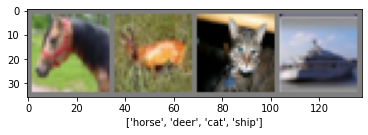

In [3]:
# Loading the dataset

## Defining the transfroms in pytorch to apply on the dataset for pre-processing.

data_transform = transforms.Compose(
                                [transforms.ToTensor(),
                                 transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

# Declaring the batch size to be used for batching the dataset.
batch_size = 4

trainset = data.CIFAR10(root='./data',train=True,download=True,transform=data_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)

testset = data.CIFAR10(root='./data',train=False,transform=data_transform)

testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=True,num_workers=2)

data_class_label = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Displaying sample Images for reference

image_iter = iter(trainloader)  # Creating a itreator object to iterate.
images,labels = image_iter.next() # Loading one set of images.

Display_images(images,labels,data_class_label)     # displaying the images using the custom display function.


## Building Training and Evaluation ML Pipeline 

In [85]:
# Training the CNN 
def Train_eval_CNN_Models(use_gpu,device_id,cnn_model,model_criterion,model_optimizer,
                          model_name ='test1' ,save_location='./trained_models',loss_freq=2000,epochs=2,google_net=False):
    
    ## Matching variables to maintain readbility
    
    Basic_CNN = cnn_model
    if use_gpu:
        Basic_CNN.cuda(device_id)    
    criterion = model_criterion
    CNN_optimzer = model_optimizer
    model_name = model_name
    Save_model_location = save_location
    loss_freq = loss_freq
    Epochs = epochs
    Training_epoch_loss_list = []
    mini_batch = []
    
    for epochs in range(Epochs):

        current_loss = 0.0
        for i , data in enumerate(trainloader,0):

            train_img,labels = data
            if(use_gpu):
                train_img,labels = train_img.cuda(device_id),labels.cuda(device_id)

            CNN_optimzer.zero_grad()# Ensuring no redual gradients is left by making it zero.

            # Forward propagation

            out = Basic_CNN(train_img)
            
            
            # Specific step for Google Net
            if google_net:
                out = out.logits
                
                
                
            loss = criterion(out,labels)

            # Backward propagation

            loss.backward() 

            # Updating weights of the CNNs various layers

            CNN_optimzer.step()

            # Output loss status

            current_loss += loss.item()
            if i % loss_freq == (loss_freq-1):      # prinitng the loss every 2000 steps
                print('Epcoh = %d/%d Trained Data Count = %5d  loss: %.3f '%(epochs + 1,Epochs,i+1,current_loss/loss_freq))
                Training_epoch_loss_list.append(current_loss)
                mini_batch.append(current_loss/loss_freq)
                current_loss = 0.0
        
    torch.save(Basic_CNN.state_dict(),Save_model_location)       
    print("Training Completed !! and model {} saved at {} ".format(model_name,Save_model_location))
    
    # Plotting the Training loss
    
    plt.plot(Training_epoch_loss_list,mini_batch)  # display the plot
    plt.ylabel('Training Loss')
    #plt.xlabel('Trained Data Count/Epoch')
    plt.show()  # Display
    

    # Testing model performance
    correct_pred = 0
    total_preds = 0

    with torch.no_grad(): # We wont track gradients as we are just testing model i.e running forward propagation only !!
        for data in testloader:
            test_images ,label = data
            if use_gpu:
                test_images ,label = test_images.cuda(device_id) ,label.cuda(device_id)        

            output = Basic_CNN(test_images)
            
            if google_net:
                output = output.logits
            
            _,predictions = torch.max(output.data,1) # Selecting the class with maximum score
            total_preds += label.size(0)
            correct_pred += (predictions == label).sum().item()
    
    #test_images ,label = test_images.cpu() ,label.cpu()  
    
    Display_images(test_images.cpu(),label.cpu(),data_class_label)
    # Plotting confusion matrix
    data = [[correct_pred],[total_preds-correct_pred]]
    plot = sn.heatmap(data,annot=True, cmap='Blues',fmt='d')
    plot.set_ylabel(['Incorrect Predictions','Correct Predictions'])
    plt.show()
    plt.tight_layout()
    print( 'Accuracy of the model on 10000 test images : %d %%' % (100*(correct_pred/total_preds) ))

## Model:0 Image classification using a Simple Neural Network

In [42]:
# Hyper parameters 
learning_rate = 0.001
momentum = 0.5
Epochs = 30
loss_freq = 2000
Save_model_location = './trained_models'
model_name = 'Model_0'

In [43]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fullconnlayer1 = nn.Linear(32*32*3,24)
        self.fullconnlayer2 = nn.Linear(24,64)
        self.fullconnlayer3 = nn.Linear(64,120)
        self.fullconnlayer4 = nn.Linear(120,10)
        
    def forward(self,z):
        z = torch.flatten(z,1) # Flattening all dimesnions except  batch to feed to a Deep network
        z = F.relu(self.fullconnlayer1(z))
        z = F.relu(self.fullconnlayer2(z))
        z = F.relu(self.fullconnlayer3(z))
        z = self.fullconnlayer4(z)
        
        return z
    
    
Basic_NN = NeuralNet()  # Initialising the netwrok.

# Defininf the loss function for the CNN

criterion = nn.CrossEntropyLoss()
CNN_optimzer = optim.SGD(Basic_NN.parameters(),lr = learning_rate, momentum=momentum)

Epcoh = 1/40 Trained Data Count =  2000  loss: 2.236 
Epcoh = 1/40 Trained Data Count =  4000  loss: 2.064 
Epcoh = 1/40 Trained Data Count =  6000  loss: 1.934 
Epcoh = 1/40 Trained Data Count =  8000  loss: 1.838 
Epcoh = 1/40 Trained Data Count = 10000  loss: 1.777 
Epcoh = 1/40 Trained Data Count = 12000  loss: 1.745 
Epcoh = 2/40 Trained Data Count =  2000  loss: 1.704 
Epcoh = 2/40 Trained Data Count =  4000  loss: 1.682 
Epcoh = 2/40 Trained Data Count =  6000  loss: 1.686 
Epcoh = 2/40 Trained Data Count =  8000  loss: 1.647 
Epcoh = 2/40 Trained Data Count = 10000  loss: 1.624 
Epcoh = 2/40 Trained Data Count = 12000  loss: 1.625 
Epcoh = 3/40 Trained Data Count =  2000  loss: 1.570 
Epcoh = 3/40 Trained Data Count =  4000  loss: 1.585 
Epcoh = 3/40 Trained Data Count =  6000  loss: 1.570 
Epcoh = 3/40 Trained Data Count =  8000  loss: 1.556 
Epcoh = 3/40 Trained Data Count = 10000  loss: 1.558 
Epcoh = 3/40 Trained Data Count = 12000  loss: 1.565 
Epcoh = 4/40 Trained Data Co

Epcoh = 26/40 Trained Data Count =  2000  loss: 1.141 
Epcoh = 26/40 Trained Data Count =  4000  loss: 1.182 
Epcoh = 26/40 Trained Data Count =  6000  loss: 1.204 
Epcoh = 26/40 Trained Data Count =  8000  loss: 1.187 
Epcoh = 26/40 Trained Data Count = 10000  loss: 1.177 
Epcoh = 26/40 Trained Data Count = 12000  loss: 1.160 
Epcoh = 27/40 Trained Data Count =  2000  loss: 1.156 
Epcoh = 27/40 Trained Data Count =  4000  loss: 1.150 
Epcoh = 27/40 Trained Data Count =  6000  loss: 1.187 
Epcoh = 27/40 Trained Data Count =  8000  loss: 1.164 
Epcoh = 27/40 Trained Data Count = 10000  loss: 1.178 
Epcoh = 27/40 Trained Data Count = 12000  loss: 1.185 
Epcoh = 28/40 Trained Data Count =  2000  loss: 1.132 
Epcoh = 28/40 Trained Data Count =  4000  loss: 1.168 
Epcoh = 28/40 Trained Data Count =  6000  loss: 1.156 
Epcoh = 28/40 Trained Data Count =  8000  loss: 1.169 
Epcoh = 28/40 Trained Data Count = 10000  loss: 1.176 
Epcoh = 28/40 Trained Data Count = 12000  loss: 1.178 
Epcoh = 29

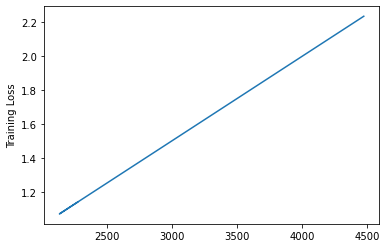

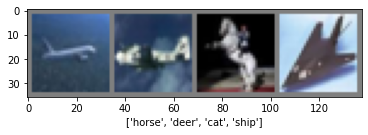

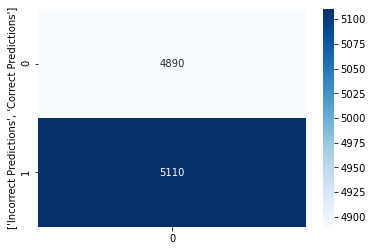

Accuracy of the model on 10000 test images : 48 %


<Figure size 432x288 with 0 Axes>

In [44]:
# Training and evaluating the Basic CNN Model
Train_eval_CNN_Models(use_gpu,device_id=0,cnn_model = Basic_NN,
                      model_criterion = criterion,
                      model_optimizer = CNN_optimzer,
                      epochs=Epochs)

### Results for different combinations of Hyperparameters


* F----> FullyConnectedLayer()
* O----> Output()

|Exp No|Epoch No   |Training Loss | Learning Rate | Accuracy(%) | momentum |
| --- | ------------- | ----------- | ------------- | ---------- | --------- | 
|  1  |     12        | 1.585      | 0.001         |  42     |  0.9    |      
|  2  |     20        | 1.504      | 0.001         |  41     |  0.9    | 
|  3  |     12        | 1.397       | 0.001         |  45     |  0.9   | 
|  4  |     20        | 1.301       | 0.001         |  47     |  0.5    | 
|  5  |     40        | 1.255       | 0.001         |  48     |  0.3   |  
|  6  |     40        | 1.214       | 0.001         |  48     |  0.3   | 
|  7  |     40        | 1.195       | 0.001         |  48    |  0.8  | 
|  8  |     40        | 1.139       | 0.001         |  48    |  0.5  | 


|Exp No|Netwrok Architecture|
|-------|-------------------|
|  1  |F(32x32x3,12)->F(12,8)->F(8,10)->O|
|  2  |F(32x32x3,12)->F(12,8)->F(8,10)->O |
|  3  |F(32x32x3,24)->F(24,12)->F(12,10)->O|
|  4  |F(32x32x3,24)->F(24,12)->F(12,10)->O|
|  5  |F(32x32x3,24)->F(24,12)->F(12,10)->O|
|  6  |F(32x32x3,24)->F(24,36)->F(36,24)->F(24,10)->O|
|  7  |F(32x32x3,24)->F(24,36)->F(36,24)->F(24,10)->O|
|  8  |F(32x32x3,24)->F(24,64)->F(64,120)->F(120,10)->O|



## Model:1 Basic Convolutional Neural Network Algorithm

In [65]:
# Hyper parameters 
learning_rate = 0.001
momentum = 0.7
Epochs = 25
loss_freq = 2000
Save_model_location = './trained_models'
model_name = 'Model_1'

In [66]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.convlayer1 = nn.Conv2d(3, 6, 5)
        self.Maxpool = nn.MaxPool2d(2,2)
        self.convlayer2 = nn.Conv2d(6,32,5)
        self.fullconnlayer1 = nn.Linear(32*5*5,24)
        self.fullconnlayer2 = nn.Linear(24,12)
        self.fullconnlayer3 = nn.Linear(12,10)
        
    def forward(self,z):
        z = self.Maxpool(F.relu(self.convlayer1(z)))
        z = self.Maxpool(F.relu(self.convlayer2(z)))
        z = torch.flatten(z,1) # Flattening all dimesnions except  batch to feed to a Deep network
        z = F.relu(self.fullconnlayer1(z))
        z = F.relu(self.fullconnlayer2(z))
        z = self.fullconnlayer3(z)
        
        return z
    
    
Basic_CNN = CNN()  # Initialising the netwrok.

# Defininf the loss function for the CNN

criterion = nn.CrossEntropyLoss()
CNN_optimzer = optim.SGD(Basic_CNN.parameters(),lr = learning_rate, momentum=momentum)



Epcoh = 1/25 Trained Data Count =  2000  loss: 2.298 
Epcoh = 1/25 Trained Data Count =  4000  loss: 2.228 
Epcoh = 1/25 Trained Data Count =  6000  loss: 2.085 
Epcoh = 1/25 Trained Data Count =  8000  loss: 1.887 
Epcoh = 1/25 Trained Data Count = 10000  loss: 1.753 
Epcoh = 1/25 Trained Data Count = 12000  loss: 1.686 
Epcoh = 2/25 Trained Data Count =  2000  loss: 1.605 
Epcoh = 2/25 Trained Data Count =  4000  loss: 1.558 
Epcoh = 2/25 Trained Data Count =  6000  loss: 1.510 
Epcoh = 2/25 Trained Data Count =  8000  loss: 1.471 
Epcoh = 2/25 Trained Data Count = 10000  loss: 1.443 
Epcoh = 2/25 Trained Data Count = 12000  loss: 1.420 
Epcoh = 3/25 Trained Data Count =  2000  loss: 1.364 
Epcoh = 3/25 Trained Data Count =  4000  loss: 1.356 
Epcoh = 3/25 Trained Data Count =  6000  loss: 1.312 
Epcoh = 3/25 Trained Data Count =  8000  loss: 1.307 
Epcoh = 3/25 Trained Data Count = 10000  loss: 1.296 
Epcoh = 3/25 Trained Data Count = 12000  loss: 1.280 
Epcoh = 4/25 Trained Data Co

Training Completed !! and model test1 saved at ./trained_models 


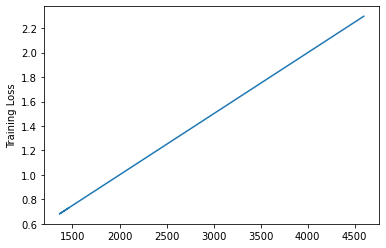

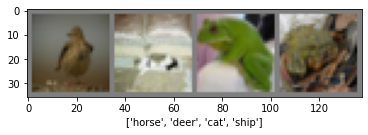

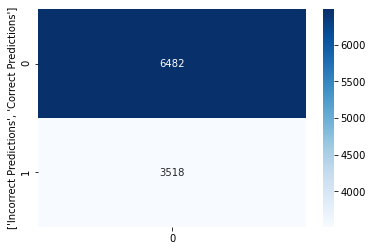

Accuracy of the model on 10000 test images : 64 %


<Figure size 432x288 with 0 Axes>

In [67]:
# Training and evaluating the Basic CNN Model
Train_eval_CNN_Models(use_gpu,device_id=0,cnn_model = Basic_CNN,
                      model_criterion = criterion,
                      model_optimizer = CNN_optimzer,
                      epochs=Epochs)
    

### Results for different combinations of Hyperparameters

* C----> ConvolutionLayer()
* F----> FullyConnectedLayer()
* M----> MaxpoolLayer()
* O----> Output()

|Exp No|Epoch No   |Training Loss | Learning Rate | Accuracy(%) | momentum | 
| --- | ------------- | ----------- | ------------- | ---------- | --------- |
|  1  |     15       | 0.763       | 0.001         |  61     |  0.9    | 
|  2  |     40        | 0.620      | 0.001         |  59     |  0.9    | 
|  3  |     15        | 0.915       | 0.001         |  63     |  0.4   | 
|  4  |     30        | 0.607       | 0.001         |  63     |  0.4   | 
|  5  |     15        | 0.104       | 0.01         |  58     |  0.4   | 
|  6  |     35        | 0.783       | 0.001         | 63     |  0.6   | 
|  7  |     25        | 0.702       | 0.001         |  64    |  0.6   | 
|  8  |     25        | 0.731       | 0.001         |  64   |  0.7   | 


|Exp No|Netwrok Architecture|
|-------|-------------------|
|1|C(3,6,5)->M(2,2)->C(6,16,5)->F(16x5x5,120)->F(120,84)->F(84,10)->O|
|2|C(3,6,5)->M(2,2)->C(6,16,5)->F(16x5x5,120)->F(120,84)->F(84,10)->O|
|3|C(3,6,5)->M(2,2)->C(6,16,5)->F(16x5x5,120)->F(120,84)->F(84,10)->O|
|4|C(3,6,5)->M(2,2)->C(6,16,5)->F(16x5x5,120)->F(120,84)->F(84,10)->O|
|5|C(3,6,5)->M(2,2)->C(6,16,5)->F(16x5x5,120)->F(120,84)->F(84,10)->O|
|6|C(3,6,5)->M(2,2)->C(6,16,5)->F(16x5x5,120)->F(120,84)->F(84,10)->O|
|7|C(3,6,5)->M(2,2)->C(6,32,5)->F(32x5x5,120)->F(120,84)->F(84,10)->O|
|8|C(3,6,5)->M(2,2)->C(6,32,5)->F(32x5x5,24)->F(24,12)->F(12,10)->O|

## Model:2 GoogleNet Convolutional Neural Network Algorithm

In [76]:
# Hyper parameters 
learning_rate = 0.1
momentum = 0.1
Epochs = 5
loss_freq = 2000
Save_model_location = './trained_models'
model_name = 'Model_2'


## Configuring model output to suit cifar 10

model_Google_Net = models.googlenet()

Final_layer = nn.Linear(model_Google_Net.fc.in_features,10)

model_Google_Net.fc = Final_layer
print("Google_Net Model Architecture:-",model_Google_Net)

# Defininf the loss function for the CNN

criterion = nn.CrossEntropyLoss()
CNN_optimzer = optim.SGD(model_Google_Net.parameters(),lr = learning_rate, momentum=momentum)



Google_Net Model Architecture:- GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, 

Epcoh = 1/5 Trained Data Count =  2000  loss: 3.092 
Epcoh = 1/5 Trained Data Count =  4000  loss: 2.281 
Epcoh = 1/5 Trained Data Count =  6000  loss: 2.281 
Epcoh = 1/5 Trained Data Count =  8000  loss: 2.252 
Epcoh = 1/5 Trained Data Count = 10000  loss: 2.232 
Epcoh = 1/5 Trained Data Count = 12000  loss: 2.184 
Epcoh = 2/5 Trained Data Count =  2000  loss: 2.172 
Epcoh = 2/5 Trained Data Count =  4000  loss: 2.161 
Epcoh = 2/5 Trained Data Count =  6000  loss: 2.132 
Epcoh = 2/5 Trained Data Count =  8000  loss: 2.142 
Epcoh = 2/5 Trained Data Count = 10000  loss: 2.157 
Epcoh = 2/5 Trained Data Count = 12000  loss: 2.119 
Epcoh = 3/5 Trained Data Count =  2000  loss: 2.105 
Epcoh = 3/5 Trained Data Count =  4000  loss: 2.101 
Epcoh = 3/5 Trained Data Count =  6000  loss: 2.125 
Epcoh = 3/5 Trained Data Count =  8000  loss: 2.272 
Epcoh = 3/5 Trained Data Count = 10000  loss: 2.224 
Epcoh = 3/5 Trained Data Count = 12000  loss: 2.212 
Epcoh = 4/5 Trained Data Count =  2000  loss: 

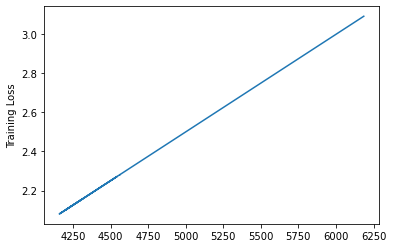

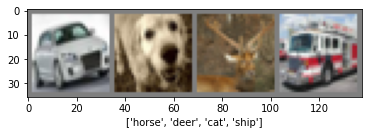

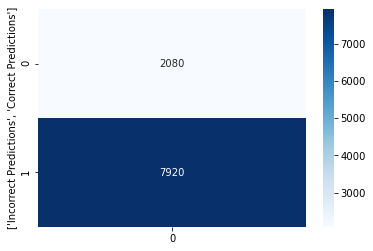

Accuracy of the model on 10000 test images : 20 %


<Figure size 432x288 with 0 Axes>

In [77]:
# Training and evaluating the GoogleNet CNN Model
Train_eval_CNN_Models(use_gpu,device_id=0,cnn_model = model_Google_Net,
                      model_criterion = criterion,
                      model_optimizer = CNN_optimzer,
                      epochs=Epochs,google_net=True)
    

### Results for different combinations of Hyper parameters


|Exp No|Epoch No   |Training Loss | Learning Rate | Accuracy(%) | momentum | 
| --- | ------------- | ----------- | ------------- | ---------- | --------- |
|  1  |     20        | 0.494       | 0.001         |  75    |  0.5    | 
|  2  |     08        | 2.104       | 0.01         |  20     |  0.8    |
|  3  |     05        | 0.104       | 0.1         | 20    |  0.1    | 



## Model:3 VGG16 Convolutional Neural Network Algorithm

In [95]:
# Hyper parameters 
learning_rate = 0.01
momentum = 0.6
Epochs = 6
loss_freq = 2000
Save_model_location = './trained_models'
model_name = 'Model_3'

## Loading model

model_vgg16 = models.vgg16(pretrained=True)

Final_layer = nn.Linear(model_vgg16.classifier[6].in_features,10)

model_vgg16.classifier[6] = Final_layer
print("VGG16 Model Architecture:-",model_vgg16)

# Defininf the loss function for the CNN

criterion = nn.CrossEntropyLoss()
CNN_optimzer = optim.SGD(model_vgg16.parameters(),lr = learning_rate, momentum=momentum)



VGG16 Model Architecture:- VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stri

Epcoh = 1/6 Trained Data Count =  2000  loss: 1.896 
Epcoh = 1/6 Trained Data Count =  4000  loss: 1.378 
Epcoh = 1/6 Trained Data Count =  6000  loss: 1.213 
Epcoh = 1/6 Trained Data Count =  8000  loss: 1.113 
Epcoh = 1/6 Trained Data Count = 10000  loss: 1.056 
Epcoh = 1/6 Trained Data Count = 12000  loss: 0.980 
Epcoh = 2/6 Trained Data Count =  2000  loss: 0.854 
Epcoh = 2/6 Trained Data Count =  4000  loss: 0.863 
Epcoh = 2/6 Trained Data Count =  6000  loss: 0.857 
Epcoh = 2/6 Trained Data Count =  8000  loss: 0.867 
Epcoh = 2/6 Trained Data Count = 10000  loss: 0.856 
Epcoh = 2/6 Trained Data Count = 12000  loss: 0.795 
Epcoh = 3/6 Trained Data Count =  2000  loss: 0.715 
Epcoh = 3/6 Trained Data Count =  4000  loss: 0.744 
Epcoh = 3/6 Trained Data Count =  6000  loss: 0.688 
Epcoh = 3/6 Trained Data Count =  8000  loss: 0.715 
Epcoh = 3/6 Trained Data Count = 10000  loss: 0.751 
Epcoh = 3/6 Trained Data Count = 12000  loss: 0.723 
Epcoh = 4/6 Trained Data Count =  2000  loss: 

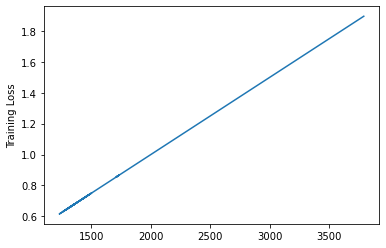

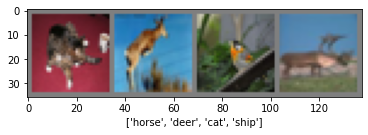

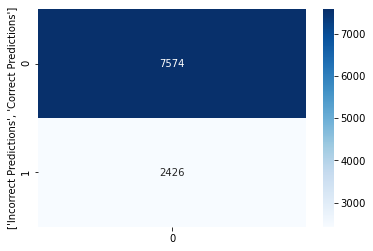

Accuracy of the model on 10000 test images : 75 %


<Figure size 432x288 with 0 Axes>

In [96]:
# Training and evaluating the VGG16 CNN Model
Train_eval_CNN_Models(use_gpu,device_id=0,cnn_model = model_vgg16,
                      model_criterion = criterion,
                      model_optimizer = CNN_optimzer,
                      epochs=Epochs)
    

### Results for different combinations of Hyperparameters


|Exp No|Epoch No   |Training Loss | Learning Rate | Accuracy(%) | momentum | 
| --- | ------------- | ----------- | ------------- | ---------- | --------- |
|  1  |     5        | 0.257      | 0.001         |  87    |  0.9    |
|  2  |     08        | 0.65      | 0.001         | 88    | 0.6    | 
|  3  |     6        |0.690       | 0.01         |  75    |  0.6   | 

## Model:4 ResNet50 Convolutional Neural Network Algorithm

In [102]:
# Hyper parameters 
learning_rate = 0.01
momentum = 0.7
Epochs = 50
loss_freq = 2000
Save_model_location = './trained_models'
model_name = 'Model_4'


## Loading model

model_ResNet_50 = models.resnet50()

Final_layer = nn.Linear(model_ResNet_50.fc.in_features,10)

model_ResNet_50.fc = Final_layer
print("model_ResNet-50 Model Architecture:-",model_ResNet_50)

# Defininf the loss function for the CNN

criterion = nn.CrossEntropyLoss()
CNN_optimzer = optim.SGD(model_ResNet_50.parameters(),lr = learning_rate, momentum=momentum)



model_ResNet-50 Model Architecture:- ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64,

Epcoh = 1/50 Trained Data Count =  2000  loss: 9.402 
Epcoh = 1/50 Trained Data Count =  4000  loss: 3.661 
Epcoh = 1/50 Trained Data Count =  6000  loss: 2.823 
Epcoh = 1/50 Trained Data Count =  8000  loss: 2.574 
Epcoh = 1/50 Trained Data Count = 10000  loss: 2.504 
Epcoh = 1/50 Trained Data Count = 12000  loss: 2.398 
Epcoh = 2/50 Trained Data Count =  2000  loss: 2.278 
Epcoh = 2/50 Trained Data Count =  4000  loss: 2.239 
Epcoh = 2/50 Trained Data Count =  6000  loss: 2.219 
Epcoh = 2/50 Trained Data Count =  8000  loss: 2.200 
Epcoh = 2/50 Trained Data Count = 10000  loss: 2.188 
Epcoh = 2/50 Trained Data Count = 12000  loss: 2.177 
Epcoh = 3/50 Trained Data Count =  2000  loss: 2.150 
Epcoh = 3/50 Trained Data Count =  4000  loss: 2.153 
Epcoh = 3/50 Trained Data Count =  6000  loss: 2.172 
Epcoh = 3/50 Trained Data Count =  8000  loss: 2.150 
Epcoh = 3/50 Trained Data Count = 10000  loss: 2.201 
Epcoh = 3/50 Trained Data Count = 12000  loss: 2.218 
Epcoh = 4/50 Trained Data Co

Epcoh = 26/50 Trained Data Count =  2000  loss: 1.884 
Epcoh = 26/50 Trained Data Count =  4000  loss: 1.877 
Epcoh = 26/50 Trained Data Count =  6000  loss: 1.865 
Epcoh = 26/50 Trained Data Count =  8000  loss: 1.862 
Epcoh = 26/50 Trained Data Count = 10000  loss: 1.867 
Epcoh = 26/50 Trained Data Count = 12000  loss: 1.856 
Epcoh = 27/50 Trained Data Count =  2000  loss: 1.854 
Epcoh = 27/50 Trained Data Count =  4000  loss: 1.855 
Epcoh = 27/50 Trained Data Count =  6000  loss: 1.846 
Epcoh = 27/50 Trained Data Count =  8000  loss: 1.840 
Epcoh = 27/50 Trained Data Count = 10000  loss: 1.853 
Epcoh = 27/50 Trained Data Count = 12000  loss: 1.875 
Epcoh = 28/50 Trained Data Count =  2000  loss: 1.842 
Epcoh = 28/50 Trained Data Count =  4000  loss: 1.877 
Epcoh = 28/50 Trained Data Count =  6000  loss: 1.878 
Epcoh = 28/50 Trained Data Count =  8000  loss: 1.843 
Epcoh = 28/50 Trained Data Count = 10000  loss: 1.838 
Epcoh = 28/50 Trained Data Count = 12000  loss: 1.842 
Epcoh = 29

Epcoh = 50/50 Trained Data Count = 12000  loss: 1.755 
Training Completed !! and model test1 saved at ./trained_models 


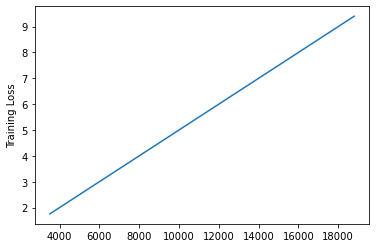

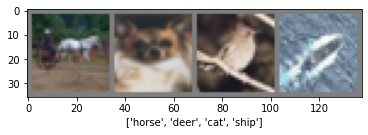

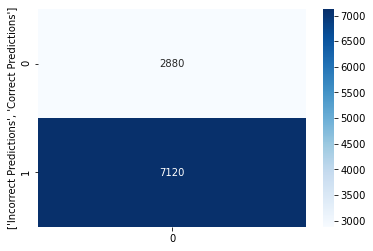

Accuracy of the model on 10000 test images : 28 %


<Figure size 432x288 with 0 Axes>

In [103]:
# Training and evaluating the ResNet50 CNN Model
Train_eval_CNN_Models(use_gpu,device_id=0,cnn_model = model_ResNet_50,
                      model_criterion = criterion,
                      model_optimizer = CNN_optimzer,
                      epochs=Epochs)
    

### Results for different combinations of Hyperparameters


|Exp No|Epoch No   |Training Loss | Learning Rate | Accuracy(%) | momentum | 
| --- | ------------- | ----------- | ------------- | ---------- | --------- | 
|  1  |     05        | 2.103      | 0.001         |  19    |  0.9  | 
|  2  |     10        | 1.958      | 0.01         | 28     |  0.7    | 
|  3  |     50        |1.755       | 0.001         |  28   |  0.7    | 

* However due to the limitation of computing capability the model is only trained up to 50 epochs!! with an unimpressive accuracy of 28%
* However the in following experiment a high accuracy of 91% was achieved after 10000 iterations over the CIFAR dataset. Link:- Khan, S. (n.d.). Resnet.ipynb at main · Shakib-IO/ResNet-50_on_CIFAR10.



## Model:6 CapsNet

* Caps net model downloaded form the following github link:- https://github.com/cedrickchee/capsule-net-pytorch.git

In [5]:
## Unable to train the model on local machine due to heavy memory requirements(> 16GB) hence considering the results from the  
##author directley.


# !cd "D:\Adelaide Study Details\Sem-1\Deep Learning Fundamentals\Assignment\Assignment-2\capsule-net-pytorch"
# ! conda
# !python ./capsule-net-pytorch/main.py --dataset cifar10 --num-conv-in-channel 3 --input-width 32 --input-height 32 --primary-unit-size 2048 --epochs 1 --num-routing 1 --use-reconstruction-loss yes --regularization-scale 0.0005


## Performance of Capsule Net on CIFAR-10(Taken from the author directly) Link:- https://github.com/cedrickchee/capsule-net-pytorch

Test Loss and Accuracy
The test losses and accuracies for CapsNet-v4 (80 epochs, 3 routing iteration, using reconstruction, regularization scale of 0.0005):

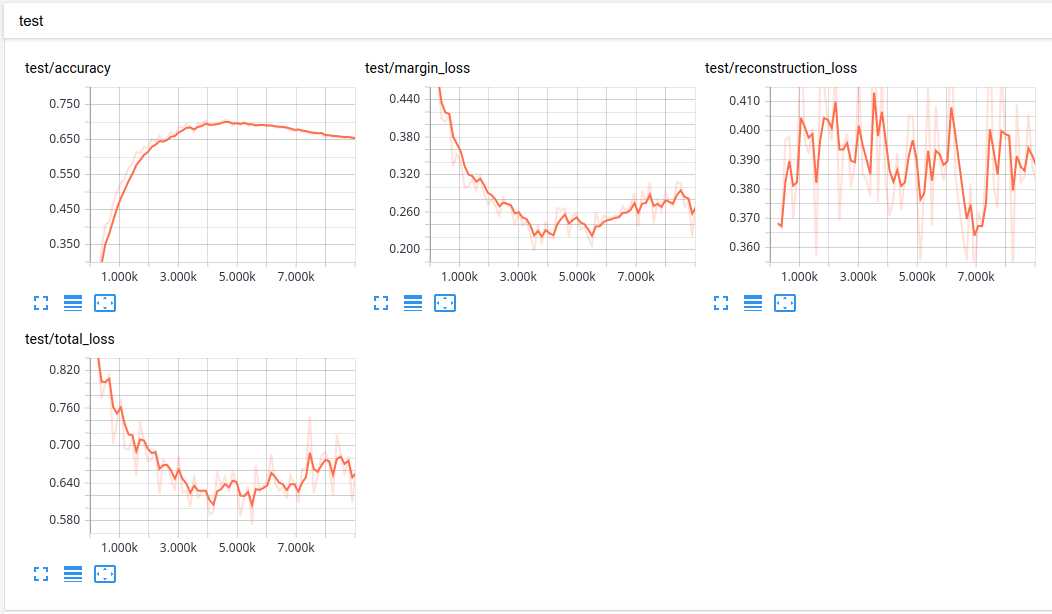

Highest test accuracy: 71%
Lowest test error: 0.5735%

## Model:7 CNN Model with proposed Imporovement !!

In [122]:
# Custom Training 

# Training the CNN 
def Train_eval_Bonous_CNN_Models(use_gpu,device_id,cnn_model,model_criterion,model_optimizer,
                          model_name ='test1' ,save_location='./trained_models',loss_freq=2000,
                          epochs=2,google_net=False,Random_update_miss = False,Randome_miss_percentage=0.25):
    
    ## Matching variables to maintain readbility
    
    Basic_CNN = cnn_model
    if use_gpu:
        Basic_CNN.cuda(device_id)    
    criterion = model_criterion
    CNN_optimzer = model_optimizer
    model_name = model_name
    Save_model_location = save_location
    loss_freq = loss_freq
    Epochs = epochs
    Training_epoch_loss_list = []
    mini_batch = []
    
    # Creating buckets for randommiss
    No_of_Rounds_to_drop = int((Epochs*Randome_miss_percentage))                      # Missing updates for 25 % of iterations.
    bucket1 = [np.random.randint(Epochs) for i in range(No_of_Rounds_to_drop)]
        
        
        
    for epochs in range(Epochs):
        
        current_loss = 0.0
        
        for i , data in enumerate(trainloader,0):
            
            
            if(epochs in bucket1 and Random_update_miss):
                print("Epcoh = %d/%d Trained Data Count = %5d loss: Randomly Skiping Update Step!!"%(epochs + 1,Epochs,i+1))
                break
                
            
            train_img,labels = data
            if(use_gpu):
                train_img,labels = train_img.cuda(device_id),labels.cuda(device_id)

            CNN_optimzer.zero_grad()# Ensuring no redual gradients is left by making it zero.

            # Forward propagation

            out = Basic_CNN(train_img)


            # Specific step for Google Net
            if google_net:
                out = out.logits



            loss = criterion(out,labels)

            # Backward propagation

            loss.backward() 

            # Updating weights of the CNNs various layers

            CNN_optimzer.step()

            # Output loss status

            current_loss += loss.item()

            if i % loss_freq == (loss_freq-1):      # prinitng the loss every 2000 steps
                print('Epcoh = %d/%d Trained Data Count = %5d  loss: %.3f '%(epochs + 1,Epochs,i+1,current_loss/loss_freq))
                Training_epoch_loss_list.append(current_loss)
                mini_batch.append(current_loss/loss_freq)
                current_loss = 0.0

    torch.save(Basic_CNN.state_dict(),Save_model_location)       
    print("Training Completed !! and model {} saved at {} ".format(model_name,Save_model_location))
    
    # Plotting the Training loss
    
    plt.plot(Training_epoch_loss_list,mini_batch)  # display the plot
    plt.ylabel('Training Loss')
    #plt.xlabel('Trained Data Count/Epoch')
    plt.show()  # Display
    
    

    # Testing model performance
    correct_pred = 0
    total_preds = 0

    with torch.no_grad(): # We wont track gradients as we are just testing model i.e running forward propagation only !!
        for data in testloader:
            test_images ,label = data
            if use_gpu:
                test_images ,label = test_images.cuda(device_id) ,label.cuda(device_id)        

            output = Basic_CNN(test_images)
            
            if google_net:
                output = output.logits
            
            _,predictions = torch.max(output.data,1) # Selecting the class with maximum score
            total_preds += label.size(0)
            correct_pred += (predictions == label).sum().item()
    
    #test_images ,label = test_images.cpu() ,label.cpu()  
    
    Display_images(test_images.cpu(),label.cpu(),data_class_label)
    # Plotting confusion matrix
    data = [[correct_pred],[total_preds-correct_pred]]
    plot = sn.heatmap(data,annot=True, cmap='Blues',fmt='d')
    plot.set_ylabel(['Incorrect Predictions','Correct Predictions'])
    plt.show()
    plt.tight_layout()
    print( 'Accuracy of the model on 10000 test images : %d %%' % (100*(correct_pred/total_preds) ))

In [123]:
# Hyper parameters 
learning_rate = 0.001
momentum = 0.6
Epochs = 25
loss_freq = 2000
Save_model_location = './trained_models'
model_name = 'Model_7'


In [125]:
## Normal Model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.convlayer1 = nn.Conv2d(3, 6, 5)
        self.Maxpool = nn.MaxPool2d(2,2)
        self.convlayer2 = nn.Conv2d(6,32,5)
        self.fullconnlayer1 = nn.Linear(32*5*5,120)
        self.fullconnlayer2 = nn.Linear(120,88)
        self.fullconnlayer3 = nn.Linear(88,10)  
        
    def forward(self,z):
        z = self.Maxpool(F.relu(self.convlayer1(z)))
        z = self.Maxpool(F.relu(self.convlayer2(z)))
        z = torch.flatten(z,1) # Flattening all dimesnions except  batch to feed to a Deep network
        z = F.relu(self.fullconnlayer1(z))
        z = F.relu(self.fullconnlayer2(z))
        z = self.fullconnlayer3(z)
        
        return z


## Droput Enabled Model
class CNN_dropout(nn.Module):
    def __init__(self,droput=False):
        super().__init__()
        self.convlayer1 = nn.Conv2d(3, 6, 5)
        self.Maxpool = nn.MaxPool2d(2,2)
        self.convlayer2 = nn.Conv2d(6,32,5)
        self.fullconnlayer1 = nn.Linear(32*5*5,120)
        self.fullconnlayer2 = nn.Linear(120,88)
        self.fullconnlayer3 = nn.Linear(88,10)
        
        self.droput = nn.Dropout(0.45)
        
        
    def forward(self,z):
        z = self.Maxpool(F.relu(self.convlayer1(z)))
        z = self.Maxpool(F.relu(self.convlayer2(z)))
        z = torch.flatten(z,1) # Flattening all dimesnions except  batch to feed to a Deep network
        z = F.relu(self.fullconnlayer1(z))
        z = self.droput(z)
        z = F.relu(self.fullconnlayer2(z))
        z = self.fullconnlayer3(z)
        
        return z
    
## Combined MaxPooling and AvgPooling Model    

class CNN_poolcombined(nn.Module):
    def __init__(self,droput=False):
        super().__init__()
        self.convlayer1 = nn.Conv2d(3, 6, 5)
        
        self.Maxpool = nn.MaxPool2d(2,2)
        self.AveragePool = nn.AvgPool2d(2)
        
        self.convlayer2 = nn.Conv2d(6,32,5)
        
        self.fullconnlayer1 = nn.Linear(32*5*5,120)
        self.fullconnlayer2 = nn.Linear(120,88)
        self.fullconnlayer3 = nn.Linear(88,10)
        
        
        
    def forward(self,z):
        z1 = self.Maxpool(F.relu(self.convlayer1(z)))
        z3 = self.AveragePool(F.relu(self.convlayer1(z)))
        z = (z1 + z3)/2         # Element Wise average
        
        
        z1 = self.Maxpool(F.relu(self.convlayer2(z)))
        z3 = self.Maxpool(F.relu(self.convlayer2(z)))
        
        z = (z1 + z3)/2

        z = torch.flatten(z,1) # Flattening all dimesnions except  batch to feed to a Deep network
        z = F.relu(self.fullconnlayer1(z))
        z = F.relu(self.fullconnlayer2(z))
        z = self.fullconnlayer3(z)
        
        return z

    
    
## Combining all techniques together

class CNN_AllTechCombined(nn.Module):
    def __init__(self,droput=False):
        super().__init__()
        self.convlayer1 = nn.Conv2d(3, 6, 5)
        
        self.Maxpool = nn.MaxPool2d(2,2)
        self.AveragePool = nn.AvgPool2d(2)
        
        self.convlayer2 = nn.Conv2d(6,32,5)
        
        self.fullconnlayer1 = nn.Linear(32*5*5,120)
        self.fullconnlayer2 = nn.Linear(120,88)
        self.fullconnlayer3 = nn.Linear(88,10)
        
        self.droput = nn.Dropout(0.45)
        
        
    def forward(self,z):
        z1 = self.Maxpool(F.relu(self.convlayer1(z)))
        z3 = self.AveragePool(F.relu(self.convlayer1(z)))
        z = (z1 + z3)/2         # Element Wise average
        
        
        z1 = self.Maxpool(F.relu(self.convlayer2(z)))
        z3 = self.Maxpool(F.relu(self.convlayer2(z)))
        
        z = (z1 + z3)/2

        z = torch.flatten(z,1) # Flattening all dimesnions except  batch to feed to a Deep network
        z = F.relu(self.fullconnlayer1(z))
        z = self.droput(z)
        z = F.relu(self.fullconnlayer2(z))
        z = self.droput(z)
        z = self.fullconnlayer3(z)
        
        return z

## Please uncomment the model to be loaded for training.


improved_CNN = CNN()  # Initialising the netwrok.
#improved_CNN = CNN_dropout() #initialising with droput enabled.
#improved_CNN = CNN_poolcombined() # initialising with multiple pooling technique enabled.
#improved_CNN = CNN_AllTechCombined() # initialising with all techniques enabled.

# Defininf the loss function for the CNN

criterion = nn.CrossEntropyLoss()
CNN_optimzer = optim.SGD(improved_CNN.parameters(),lr = learning_rate, momentum=momentum)


Epcoh = 1/25 Trained Data Count =     1 loss: Randomly Skiping Update Step!!
Epcoh = 2/25 Trained Data Count =     1 loss: Randomly Skiping Update Step!!
Epcoh = 3/25 Trained Data Count =     1 loss: Randomly Skiping Update Step!!
Epcoh = 4/25 Trained Data Count =  2000  loss: 2.302 
Epcoh = 4/25 Trained Data Count =  4000  loss: 2.275 
Epcoh = 4/25 Trained Data Count =  6000  loss: 2.109 
Epcoh = 4/25 Trained Data Count =  8000  loss: 1.968 
Epcoh = 4/25 Trained Data Count = 10000  loss: 1.854 
Epcoh = 4/25 Trained Data Count = 12000  loss: 1.772 
Epcoh = 5/25 Trained Data Count =  2000  loss: 1.651 
Epcoh = 5/25 Trained Data Count =  4000  loss: 1.595 
Epcoh = 5/25 Trained Data Count =  6000  loss: 1.554 
Epcoh = 5/25 Trained Data Count =  8000  loss: 1.506 
Epcoh = 5/25 Trained Data Count = 10000  loss: 1.462 
Epcoh = 5/25 Trained Data Count = 12000  loss: 1.459 
Epcoh = 6/25 Trained Data Count =  2000  loss: 1.405 
Epcoh = 6/25 Trained Data Count =  4000  loss: 1.379 
Epcoh = 6/25 

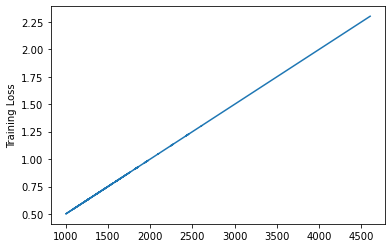

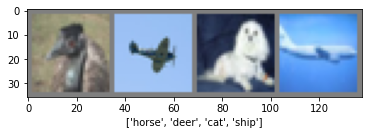

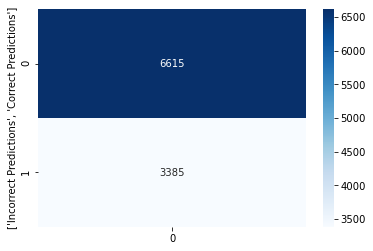

Accuracy of the model on 10000 test images : 66 %


<Figure size 432x288 with 0 Axes>

In [127]:
# Set Random_update_miss = True to enable random miss. Random miss percentage can be set by passing Randome_miss_percentage
# Parameter.

# Training and evaluating of Custom CNN Model
Train_eval_Bonous_CNN_Models(use_gpu=False,device_id=1,cnn_model = improved_CNN,
                      model_criterion = criterion,
                      model_optimizer = CNN_optimzer,
                      epochs=Epochs,Random_update_miss = True,Randome_miss_percentage=0.45)
    

### Results for different combinations of Hyper parameters

* C----> ConvolutionLayer()
* F----> FullyConnectedLayer()
* M----> MaxpoolLayer()
* O----> Output()
* Here we will select the best Hyperparameters and architecutre from the results of training Basic CNN (Model-1)

|Exp No|Epoch No   |Training Loss | Learning Rate | Accuracy(%) | momentum | 
| --- | ------------- | ----------- | ------------- | ---------- | --------- | 
|  1  |     25        | 0.739      | 0.001         |  64     |  0.7   |
|  2  |     25       | 0.776     | 0.001         |  64    |  0.7    | 
|  3  |     25        | 0.804      | 0.001         | 59    |  0.7    | 
|  4  |     25        | 0.953     | 0.001         |  59  |  0.7    | 
|  5  |     25        | 0.389    | 0.001         |  61  |  0.5    | 
|  6  |     25        |0.479      | 0.001         |  60    |  0.5    | 
|  7  |     25        | 0.677       | 0.001         |  61     |  0.5   |
|  8  |     40        | 0.892       | 0.001         |  62     |  0.7   |
|  9  |     40        | 0.770       | 0.001         |  63    |  0.7   |
|  10  |     25        | 0.628      | 0.001         |  66   |  0.6  |
| 11  |     27        | 0.552      | 0.001         |  65   |  0.5  |

|Exp No|Netwrok Architecture|Special Changes|
|-------|--------------------|--------------|
|1|C(3,6,5)->M(2,2)->C(6,32,5)->F(32x5x5,24)->F(24,12)->F(12,10)->O| No Change|
|2|C(3,6,5)->M(2,2)->C(6,32,5)->F(32x5x5,24)->F(24,12)->F(12,10)->O| Random Parameter Update Miss 25%|
|3|C(3,6,5)->M(2,2)->C(6,32,5)->F(32x5x5,24)->F(24,12)->F(12,10)->O| Dropout Enabled 25%|
|4|C(3,6,5)->M(2,2)->C(6,32,5)->F(32x5x5,24)->F(24,12)->F(12,10)->O| Random Parameter Update Miss + Dropout Enabled|
|5|C(3,6,5)->M(2,2)->C(6,32,5)->F(32x5x5,120)->F(120,88)->F(88,10)->O|Random Parameter Update Miss 45% + Dropout 45%|
|6|C(3,6,5)->M(2,2)->C(6,32,5)->F(32x5x5,24)->F(24,12)->F(12,10)->O|Multi Pooling Merge|
|7|C(3,6,5)->M(2,2)->C(6,32,5)->F(32x5x5,24)->F(24,12)->F(12,10)->O|Multi Pooling Merge + Random Parameter Update Miss|
|8|C(3,6,5)->M(2,2)->C(6,32,5)->F(32x5x5,24)->F(24,12)->F(12,10)->O|Multi Pooling Merge + Random Parameter Update Miss + Dropout Enabled|
|9|C(3,6,5)->M(2,2)->C(6,32,5)->F(32x5x5,24)->F(24,12)->F(12,10)->O|Random Parameter Update Miss 45%|
|10|C(3,6,5)->M(2,2)->C(6,32,5)->F(32x5x5,120)->F(120,88)->F(88,10)->O|Random Parameter Update Miss 45%|
|11|C(3,6,5)->M(2,2)->C(6,32,5)->F(32x5x5,120)->F(120,88)->F(88,10)->O|Random Parameter Update Miss 55%|

|Exp No|Special Modifications|
|--------|-------------------|
|1|No Change|
|2|Random Parameter Update Miss 25%|
|3|Dropout Enabled 25%|
|4|Random Parameter Update Miss + Dropout Enabled|
|5|Random Parameter Update Miss 45% + Dropout 45%|
|6|Multi Pooling Merge|
|7|Multi Pooling Merge + Random Parameter Update Miss|
|8|Multi Pooling Merge + Random Parameter Update Miss + Dropout Enabled|
|9|Random Parameter Update Miss 45%|
|10|Random Parameter Update Miss 45%|
|11|Random Parameter Update Miss 55%|

* Author: Ankit Yadav (a1791904)